*backpropagation* is the backbone of every neural networks engine, e.g. pytorch. 
maybe change the name to **chadGrad**

In [40]:
# Value object takes a single scalar value and wraps it
class Value:
    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        # the children nodes resulting in Value object
        self._prev = set(_children)
        # the operation resulting in Value object
        self._op = _op
        # the label for a Value
        self._label = _label
        # by default we assume that a Value doesn't effect the output loss function,
        # this is the gradient of the loss function, L, wrt this specific Value
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self._label})"
    
    # keep track of the children in mul and add ops
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [48]:
a = Value(3.0, _label='a')
b = Value(2.0, _label='b')
c = a + b; c._label='c'
d = a * b; d._label='d'
e = d + c; e._label='e'
f = Value(data=0.5, _label='f')
L = f * e; L._label='L'
print(a)
print(a.__add__(b))
print(c)
print(d)
print(d._prev)
print(d._op)
print(L)

Value(data=3.0, label=a)
Value(data=5.0, label=)
Value(data=5.0, label=c)
Value(data=6.0, label=d)
{Value(data=2.0, label=b), Value(data=3.0, label=a)}
*
Value(data=5.5, label=L)


In [53]:
from graphviz import Digraph

def trace(root):
    # the set of all nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any node (Value, op) in the graph put the value repr in a record (rectangle)
        dot.node(name=uid, label=f"{n._label}: {n.data:0.3f} | g:{n.grad}", shape="record")
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    # connect n1 and n2 with an edge
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
        
    return dot
            

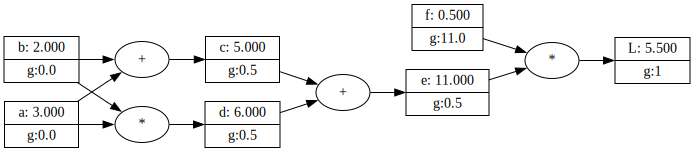

In [54]:
draw_dot(L)

Now we have to calculate the gradient of loss function, L, with respect to each node. We know that the $\frac{\partial L}{\partial L} = 1$, and by the above computation graph we can deduce that:
$$
\begin{align}
\frac{\partial L}{\partial f} &= e, \\
\frac{\partial L}{\partial e} &= f, \\
\frac{\partial L}{\partial c} &= \frac{\partial L}{\partial e}\frac{\partial e}{\partial c} = f \times 1 = f
\end{align}
$$

we can see that the role of a plus node is to just pass on the gradient to the previous nodes in the compuation graph.

In [51]:
L.grad = 1
f.grad = e.data
e.grad = f.data
c.grad = e.grad
d.grad = e.grad

Now we can do the same for the previous add and mul nodes:

$$
\begin{align}
\frac{\partial L}{\partial a} &= \frac{\partial L}{\partial d} \frac{\partial d}{\partial a} + 
\frac{\partial L}{\partial c}\frac{\partial c}{\partial a} \\
&= 0.5 \times b + 0.5 \times 1 = 0.5 \times 2 + 0.5 = 1.5
\end{align}
$$

$$
\begin{align}
\frac{\partial L}{\partial b} &= \frac{\partial L}{\partial c} \frac{\partial c}{\partial b} + 
\frac{\partial L}{\partial d}\frac{\partial d}{\partial b} \\
&= 0.5 \times 1 + 0.5 \times a = 0.5 \times 1 + 0.5 * 3 = 2
\end{align}
$$

In [55]:
a.grad = 1.5
b.grad = 2

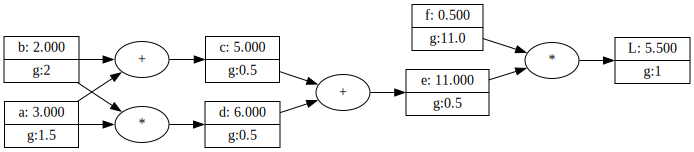

In [57]:
draw_dot(L)

Now we can actually use these backpropagated grads to reduce the final loss in each iteration, we need to just nudge the values by the grads, in the opposite direction of the grad:

In [74]:
a.data -= 0.01 * a.grad
b.data -= 0.01 * b.grad
f.data -= 0.01 * f.grad
c = a + b
d = a * b
e = c + d
L = e * f
L

Value(data=4.241366999999999, label=)